# Protocols

In [9]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy import random


c = "1"
d = "0"

protocol = QuantumCircuit(2)

# prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# A operations
if d == "1":
    protocol.z(0)
if c == "0":
    protocol.z(0)
protocol.barrier()

# B actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw())

┌───┐      ░  ░      ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├──■───░──░───■──┤ H ├─░─┤M├───
        └───┘┌─┴─┐ ░  ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──░─┤ X ├──────░──╫─┤M├
             └───┘ ░  ░ └───┘      ░  ║ └╥┘
meas: 2/══════════════════════════════╩══╩═
                                      0  1

Measured 00 with frequency 1.0


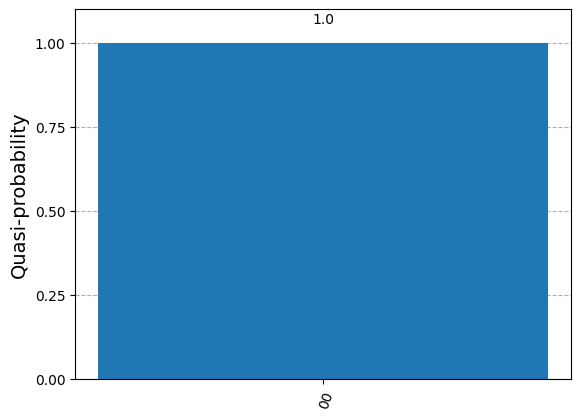

In [3]:
result = Sampler().run(protocol).result()
statistics = result.quasi_dists[0].binary_probabilities()

for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")

display(plot_histogram(statistics))

In [10]:
rbg = QuantumRegister(1, "randomizer")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'randomizer' qubit twice to generate Alice's bits c and d.
test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()

# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw())


░ ┌───┐┌─┐┌───┐┌─┐ ░                                »
randomizer: ───────────░─┤ H ├┤M├┤ H ├┤M├─░────────────────────────────────»
            ┌───┐      ░ └───┘└╥┘└───┘└╥┘ ░ ┌────── ┌───┐ ───────┐ ┌────── »
         A: ┤ H ├──■───░───────╫───────╫──░─┤ If-0  ┤ Z ├  End-0 ├─┤ If-0  »
            └───┘┌─┴─┐ ░       ║       ║  ░ └──╥─── └───┘ ───────┘ └──╥─── »
         B: ─────┤ X ├─░───────╫───────╫──░────╫──────────────────────╫────»
                 └───┘ ░       ║       ║  ░ ┌──╨──┐                   ║    »
 Alice d: 1/═══════════════════╬═══════╩════╡ 0x1 ╞═══════════════════╬════»
                               ║       0    └─────┘                ┌──╨──┐ »
 Alice c: 1/═══════════════════╩═══════════════════════════════════╡ 0x1 ╞═»
                               0                                   └─────┘ »
   Bob d: 1/═══════════════════════════════════════════════════════════════»
                                                                           »
   Bob c: 1/═══════════════════════════════════════════════════════════════»
                                                                           »
«                            ░            ░       
«randomizer: ────────────────░────────────░───────
«            ┌───┐ ───────┐  ░      ┌───┐ ░ ┌─┐   
«         A: ┤ X ├  End-0 ├──░───■──┤ H ├─░─┤M├───
«            └───┘ ───────┘  ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
«         B: ────────────────░─┤ X ├──────░──╫─┤M├
«                            ░ └───┘      ░  ║ └╥┘
« Alice d: 1/════════════════════════════════╬══╬═
«                                            ║  ║ 
« Alice c: 1/════════════════════════════════╬══╬═
«                                            ║  ║ 
«   Bob d: 1/════════════════════════════════╩══╬═
«                                            0  ║ 
«   Bob c: 1/═══════════════════════════════════╩═
«                                               0

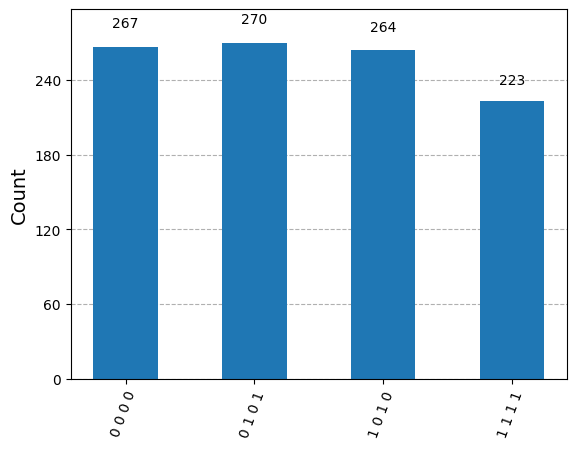

In [11]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))